# Section 1 | Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF
from scipy.sparse import csr_matrix

In [2]:
data = pd.read_csv("data/Tempat-Wisata-Toba-Preprocessing.csv")

In [3]:
data.shape

(43226, 9)

In [4]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'address', 'PlaceID',
       'Nama_tempat_wisata', 'Category', 'ReviewerId', 'Rating', 'Reviews'],
      dtype='object')

In [5]:
data = data.rename(columns={'ReviewerId': 'user_id', 'PlaceID': 'item_id', 'Rating': 'rating'})
data['rating'] = data['rating'].astype(float)
data.dropna(inplace=True)
data.head(5)

,Unnamed: 0.1,Unnamed: 0,address,item_id,Nama_tempat_wisata,Category,user_id,rating,Reviews
1,1,1,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.119090e+20,5.0,bagus
3,3,3,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.130720e+20,5.0,sangat menyenagkan
4,4,4,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.061730e+20,5.0,bebas foto dimana aja cuma 2k
6,6,6,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.142390e+20,5.0,amazing pengen kesini lagi
8,8,8,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.047430e+20,3.0,jalan menuju lokasi perlu diperhatikan oleh pe...


In [6]:
col_to_drop = ['Unnamed: 0.1', 'Unnamed: 0', 'address', 'Category', 'Reviews']
data = data.drop(columns=col_to_drop)
data.head()

,item_id,Nama_tempat_wisata,user_id,rating
1,0,PASIR PUTIH LUMBAN BULBUL,1.119090e+20,5.0
3,0,PASIR PUTIH LUMBAN BULBUL,1.130720e+20,5.0
4,0,PASIR PUTIH LUMBAN BULBUL,1.061730e+20,5.0
6,0,PASIR PUTIH LUMBAN BULBUL,1.142390e+20,5.0
8,0,PASIR PUTIH LUMBAN BULBUL,1.047430e+20,3.0


In [7]:
data.shape

(22166, 4)

# Section 2 | Data Splitting

In [8]:
# Step 1: Split into 85% training+validation and 15% test
train_val_data, test_data = train_test_split(data, test_size=0.15, random_state=42)
# Step 2: Define validation size as 17% of train+validation, rounded up
val_size = int(len(train_val_data) * 0.17) + 1
# Step 3: Split 85% data into training (about 70% of original) and validation (about 15% of original)
train_data, val_data = train_test_split(train_val_data, test_size=val_size, random_state=42)
# Check sizes
print(f"Train data size: {train_data.shape}")
print(f"Validation data size: {val_data.shape}")
print(f"Test data size: {test_data.shape}")

Train data size: (15638, 4)
Validation data size: (3203, 4)
Test data size: (3325, 4)


# Section 3 | Create User-Item Matrix

In [9]:
def create_user_item_matrix(data, user_col='user_id', item_col='Nama_tempat_wisata', rating_col='rating'):
    data = data.groupby([user_col, item_col])[rating_col].mean().reset_index()
    return data.pivot(index=user_col, columns=item_col, values=rating_col).fillna(0)

# Apply the function to create matrices for each split
train_matrix = create_user_item_matrix(train_data)
val_matrix = create_user_item_matrix(val_data).reindex(columns=train_matrix.columns, fill_value=0)
test_matrix = create_user_item_matrix(test_data).reindex(columns=train_matrix.columns, fill_value=0)

In [10]:
train_matrix

Nama_tempat_wisata,Aek Rangat Pangururan,Aek Sipangolu Bakkara,Air Terjun Efrata,Air Terjun Janji,Air Terjun Pandumaan,Air Terjun Sampuran,Air Terjun Siboruon,Air Terjun Situmurun,Air Terjun Taman Eden 100,Air Terjun Tombak Pangaribuan,...,Tao Silalahi Hotel,Tarabunga,Tempat Pengasingan Soekarno,The Kaldera,Tombak Sulusulu,Tugu D.I PANJAITAN,Tugu Toga Aritonang,WF Coffee&Resto,Wisata Bukit Gibeon,Wisata Rumah Pohon
user_id,,,,,,,,,,,,,,,,,,,,,
1.000030e+20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.000040e+20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.000090e+20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.000100e+20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.000120e+20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.184390e+20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.184410e+20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.184430e+20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
train_matrix_sparse = csr_matrix(train_matrix.values)
val_matrix_sparse = csr_matrix(val_matrix.values)
test_matrix_sparse = csr_matrix(test_matrix.values)

In [12]:
train_matrix_sparse.shape

(8905, 98)

# Define RMSE, MAE, MAP, Precision, & Recall Calculation Function 

In [13]:
def compute_rmse(true_matrix, approx_matrix):
    return np.sqrt(mean_squared_error(true_matrix.ravel(), approx_matrix.ravel()))

In [14]:
from sklearn.metrics import mean_absolute_error

def compute_mae(true_matrix, approx_matrix):
    return mean_absolute_error(true_matrix.ravel(), approx_matrix.ravel())

In [15]:
def precision_at_k(true_matrix, approx_matrix, k=10):
    """
    Computes Precision@k for the recommendation system.
    """
    precision = []
    for i in range(true_matrix.shape[0]):
        true_ratings = true_matrix.iloc[i, :].values  # Use .iloc for row-based indexing
        approx_ratings = approx_matrix.iloc[i, :].values  # Use .iloc for row-based indexing
        
        # Get indices of top-k recommended items
        top_k_indices = np.argsort(approx_ratings)[::-1][:k]
        
        # Check how many of the top-k recommended items are actually relevant (non-zero rating)
        relevant_items = np.sum(true_ratings[top_k_indices] > 0)
        precision.append(relevant_items / k)
    
    return np.mean(precision)

In [16]:
def recall_at_k(true_matrix, approx_matrix, k=10):
    """
    Computes Recall@k for the recommendation system.
    """
    recall = []
    for i in range(true_matrix.shape[0]):
        true_ratings = true_matrix.iloc[i, :].values  # Use .iloc for row-based indexing
        approx_ratings = approx_matrix.iloc[i, :].values  # Use .iloc for row-based indexing
        
        # Get indices of top-k recommended items
        top_k_indices = np.argsort(approx_ratings)[::-1][:k]
        
        # Check how many of the relevant items (non-zero ratings) are retrieved in the top-k
        relevant_items = np.sum(true_ratings[top_k_indices] > 0)
        total_relevant = np.sum(true_ratings > 0)
        
        # If there are no relevant items for the user, avoid division by zero
        if total_relevant == 0:
            recall.append(0)
        else:
            recall.append(relevant_items / total_relevant)
    
    return np.mean(recall)

In [17]:
def average_precision_at_k(true_matrix, approx_matrix, k=10):
    """
    Computes Average Precision@k for each user, then returns the Mean Average Precision@k.
    """
    avg_precision = []
    for i in range(true_matrix.shape[0]):
        true_ratings = true_matrix.iloc[i, :].values  # Use .iloc for row-based indexing
        approx_ratings = approx_matrix.iloc[i, :].values  # Use .iloc for row-based indexing
        
        # Get indices of top-k recommended items
        top_k_indices = np.argsort(approx_ratings)[::-1][:k]
        
        # Calculate precision at each rank in the top-k list
        relevant_items = np.sum(true_ratings[top_k_indices] > 0)
        precision_at_i = np.array([1 if true_ratings[idx] > 0 else 0 for idx in top_k_indices])
        precision_at_i_cumsum = np.cumsum(precision_at_i) / (np.arange(k) + 1)
        
        # Average Precision for this user
        avg_precision_user = np.sum(precision_at_i_cumsum * precision_at_i) / relevant_items if relevant_items > 0 else 0
        avg_precision.append(avg_precision_user)
    
    return np.mean(avg_precision)

# ALS

## No Tuning

In [18]:
import implicit

In [19]:
als_model = implicit.als.AlternatingLeastSquares(factors=10, regularization=0.1, iterations=20, random_state=42)

C:\Users\walkervalentinus\AppData\Roaming\Python\Python311\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


In [20]:
als_model.fit(train_matrix_sparse)

  0%|          | 0/20 [00:00<?, ?it/s]

In [21]:
user_factors = als_model.user_factors
item_factors = als_model.item_factors

predicted_ratings = user_factors.dot(item_factors.T)

predicted_matrix = pd.DataFrame(predicted_ratings, columns=train_matrix.columns, index=train_matrix.index)

In [22]:
print(f"Test Matrix shape: {test_matrix.shape}")
print(f"Predicted Matrix shape: {predicted_matrix.shape}")

Test Matrix shape: (2838, 98)
Predicted Matrix shape: (8905, 98)


In [23]:
# Reindex to match the test set
predicted_matrix = predicted_matrix.reindex(index=test_matrix.index, columns=test_matrix.columns, fill_value=0)

In [24]:
print(f"Test Matrix shape: {test_matrix.shape}")
print(f"Predicted Matrix shape: {predicted_matrix.shape}")

Test Matrix shape: (2838, 98)
Predicted Matrix shape: (2838, 98)


In [25]:
test_rmse = compute_rmse(test_matrix.values, predicted_matrix.values)
test_mae = compute_mae(test_matrix.values, predicted_matrix.values)

print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test RMSE: 0.5091
Test MAE: 0.1063


In [26]:
k = 10
precision_k = precision_at_k(test_matrix, predicted_matrix, k)
recall_k = recall_at_k(test_matrix, predicted_matrix, k)
map_k = average_precision_at_k(test_matrix, predicted_matrix, k)

In [27]:
print(f"Precision@{k}: {precision_k:.4f}")
print(f"Recall@{k}: {recall_k:.4f}")
print(f"MAP@{k}: {map_k:.4f}")

Precision@10: 0.0273
Recall@10: 0.2313
MAP@10: 0.0840


In [28]:
k = 5
precision_k5 = precision_at_k(test_matrix, predicted_matrix, k)
recall_k5 = recall_at_k(test_matrix, predicted_matrix, k)
map_k5 = average_precision_at_k(test_matrix, predicted_matrix, k)

In [29]:
print(f"Precision@{k}: {precision_k5:.4f}")
print(f"Recall@{k}: {recall_k5:.4f}")
print(f"MAP@{k}: {map_k5:.4f}")

Precision@5: 0.0311
Recall@5: 0.1312
MAP@5: 0.0699


## With Tuning

In [30]:
from sklearn.model_selection import ParameterGrid

In [31]:
train_rmse_list = []
val_rmse_list = []
param_combinations = []

In [32]:
param_grid = {
    'factors': [10, 20, 50],
    'regularization': [0.05, 0.1, 0.2],
    'iterations': [10, 20, 30]
}

best_rmse = float('inf')
best_params = None

In [33]:
for params in ParameterGrid(param_grid):
    als_model = implicit.als.AlternatingLeastSquares(factors=params['factors'],
                                                     regularization=params['regularization'],
                                                     iterations=params['iterations'],
                                                     random_state=42)
    als_model.fit(train_matrix_sparse)

    # Predict ratings for training users (this works as before)
    train_predicted_ratings = als_model.user_factors.dot(als_model.item_factors.T)
    train_predicted_matrix = pd.DataFrame(train_predicted_ratings, 
                                          columns=train_matrix.columns, 
                                          index=train_matrix.index)

    # Predict ratings for validation set
    val_predicted_ratings = als_model.user_factors.dot(als_model.item_factors.T)

    # Get the indices of users in the validation set
    common_users = val_matrix.index.intersection(train_matrix.index)

    # Find the positions of the common users in the training user factors (ALS)
    common_user_indices = [train_matrix.index.get_loc(user) for user in common_users]

    # Get the corresponding predicted ratings for the common users
    val_predicted_ratings_filtered = val_predicted_ratings[common_user_indices, :]

    # Reindex the validation matrix to match the common users and items
    val_predicted_matrix = pd.DataFrame(val_predicted_ratings_filtered, 
                                        columns=train_matrix.columns, 
                                        index=common_users)

    # Compute RMSE for training and validation sets
    train_rmse = compute_rmse(train_matrix.values, train_predicted_matrix.values)
    val_rmse = compute_rmse(val_matrix.loc[common_users, :].values, val_predicted_matrix.values)

    # Store results
    train_rmse_list.append(train_rmse)
    val_rmse_list.append(val_rmse)
    param_combinations.append(params)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [34]:
tuning_results = pd.DataFrame({
    'params': [str(params) for params in param_combinations],
    'train_rmse': train_rmse_list,
    'val_rmse': val_rmse_list
})

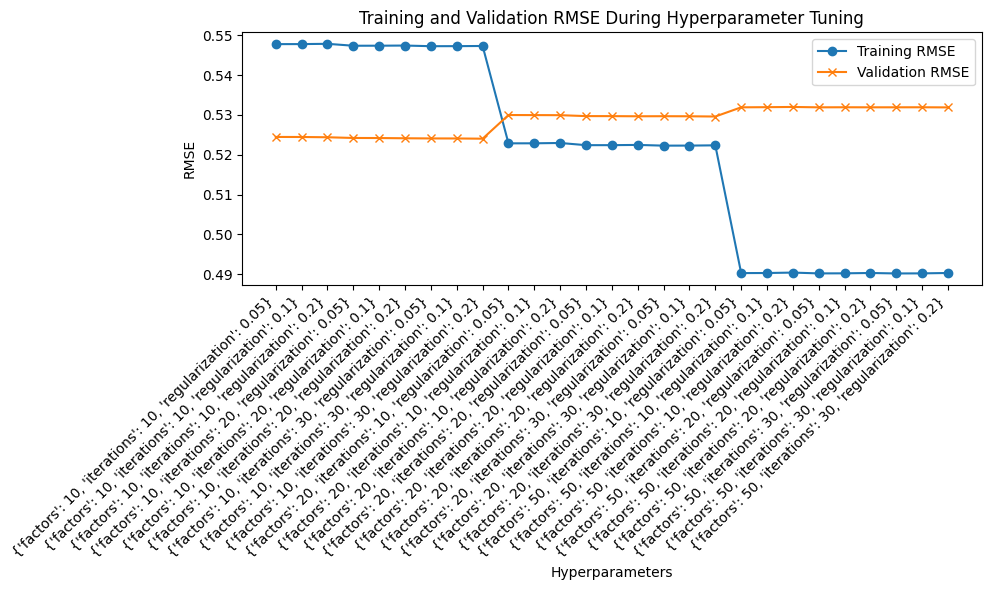

In [35]:
plt.figure(figsize=(10, 6))
# Plot training RMSE and validation RMSE
plt.plot(tuning_results['params'], tuning_results['train_rmse'], label='Training RMSE', marker='o')
plt.plot(tuning_results['params'], tuning_results['val_rmse'], label='Validation RMSE', marker='x')

# Adding labels and title
plt.xlabel('Hyperparameters')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE During Hyperparameter Tuning')
plt.xticks(rotation=45, ha='right')  # Rotate labels for readability
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
als_tune = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.2, iterations=30, random_state=42)

In [37]:
als_tune.fit(train_matrix_sparse)

  0%|          | 0/30 [00:00<?, ?it/s]

In [38]:
user_factors = als_tune.user_factors
item_factors = als_tune.item_factors

predicted_ratings = user_factors.dot(item_factors.T)

predicted_matrix = pd.DataFrame(predicted_ratings, columns=train_matrix.columns, index=train_matrix.index)

In [39]:
print(f"Test Matrix shape: {test_matrix.shape}")
print(f"Predicted Matrix shape: {predicted_matrix.shape}")

Test Matrix shape: (2838, 98)
Predicted Matrix shape: (8905, 98)


In [40]:
# Reindex to match the test set
predicted_matrix = predicted_matrix.reindex(index=test_matrix.index, columns=test_matrix.columns, fill_value=0)

In [41]:
print(f"Test Matrix shape: {test_matrix.shape}")
print(f"Predicted Matrix shape: {predicted_matrix.shape}")

Test Matrix shape: (2838, 98)
Predicted Matrix shape: (2838, 98)


In [42]:
test_rmse_tune = compute_rmse(test_matrix.values, predicted_matrix.values)
test_mae_tune = compute_mae(test_matrix.values, predicted_matrix.values)

print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test RMSE: 0.5091
Test MAE: 0.1063


In [43]:
k = 10
precision_k_tune = precision_at_k(test_matrix, predicted_matrix, k)
recall_k_tune = recall_at_k(test_matrix, predicted_matrix, k)
map_k_tune = average_precision_at_k(test_matrix, predicted_matrix, k)

In [44]:
print(f"Precision@{k}: {precision_k_tune:.4f}")
print(f"Recall@{k}: {recall_k_tune:.4f}")
print(f"MAP@{k}: {map_k_tune:.4f}")

Precision@10: 0.0102
Recall@10: 0.0876
MAP@10: 0.0334


In [45]:
k = 5
precision_k_tune5 = precision_at_k(test_matrix, predicted_matrix, k)
recall_k_tune5 = recall_at_k(test_matrix, predicted_matrix, k)
map_k_tune5 = average_precision_at_k(test_matrix, predicted_matrix, k)

In [46]:
print(f"Precision@{k}: {precision_k_tune5:.4f}")
print(f"Recall@{k}: {recall_k_tune5:.4f}")
print(f"MAP@{k}: {map_k_tune5:.4f}")

Precision@5: 0.0112
Recall@5: 0.0477
MAP@5: 0.0275


In [47]:
before_tuning_error = {
    "val_rmse": test_rmse,
    "val_mae": test_mae,
}

In [48]:
before_tuning_evaluation = {
    "val_map": map_k,
    "val_precision": precision_k,
    "val_recall": recall_k
}

In [49]:
after_tuning_error = {
    "val_rmse": test_rmse_tune,
    "val_mae": test_mae_tune,
}

In [50]:
after_tuning_evaluation = {
    "val_map": map_k_tune,
    "val_precision": precision_k_tune,
    "val_recall": recall_k_tune
}

In [51]:
error_metrics_df = pd.DataFrame({
    "Metric": ["RMSE", "MAE"],
    "Before Tuning": [before_tuning_error["val_rmse"], before_tuning_error["val_mae"]],
    "After Tuning": [after_tuning_error["val_rmse"], after_tuning_error["val_mae"]]
})

evaluation_metrics_df = pd.DataFrame({
    "Metric": ["MAP", "Precision", "Recall"],
    "Before Tuning": [before_tuning_evaluation["val_map"], before_tuning_evaluation["val_precision"], before_tuning_evaluation["val_recall"]],
    "After Tuning": [after_tuning_evaluation["val_map"], after_tuning_evaluation["val_precision"], after_tuning_evaluation["val_recall"]]
})

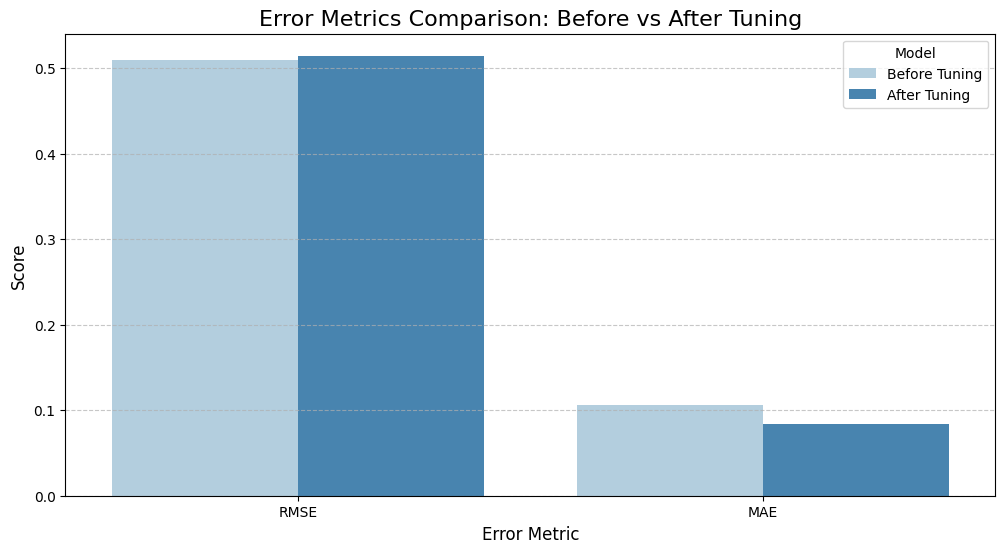

In [52]:
plt.figure(figsize=(12, 6))
error_metrics_melted = error_metrics_df.melt(id_vars="Metric", var_name="Model", value_name="Score")
sns.barplot(data=error_metrics_melted, x="Metric", y="Score", hue="Model", palette="Blues")
plt.title("Error Metrics Comparison: Before vs After Tuning", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Error Metric", fontsize=12)
plt.legend(title="Model")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

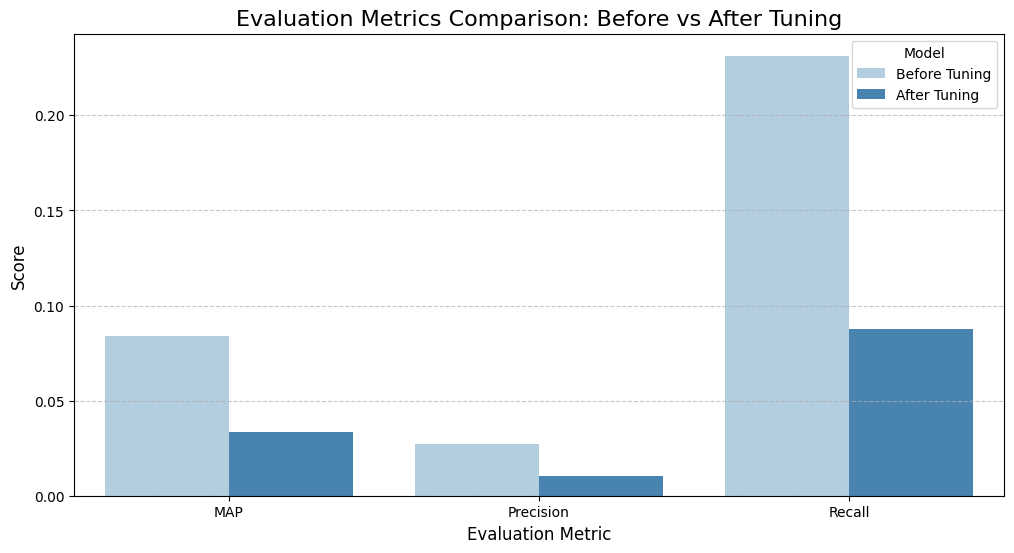

In [53]:
plt.figure(figsize=(12, 6))
evaluation_metrics_melted = evaluation_metrics_df.melt(id_vars="Metric", var_name="Model", value_name="Score")
sns.barplot(data=evaluation_metrics_melted, x="Metric", y="Score", hue="Model", palette="Blues")
plt.title("Evaluation Metrics Comparison: Before vs After Tuning", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Evaluation Metric", fontsize=12)
plt.legend(title="Model")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Recommendation for user ALS

In [54]:
def get_top_n_recommendations(user_id, model, train_matrix, n=10):
    # Ensure that the user_id corresponds to an actual user in the train_matrix
    try:
        # Get the integer index of the user_id in the train_matrix
        user_index = train_matrix.index.get_loc(user_id)
    except KeyError:
        raise ValueError(f"User ID {user_id} not found in the train matrix.")
    
    # Get the user and item factors from the trained ALS model
    user_factors = model.user_factors
    item_factors = model.item_factors

    # Predict ratings for all items (dot product of user and item factors)
    predicted_ratings = user_factors[user_index, :].dot(item_factors.T)
    
    # Get the indices of the top n recommendations
    top_n_indices = np.argsort(predicted_ratings)[::-1][:n]

    # Map item indices to item IDs or names (if applicable)
    recommended_items = train_matrix.columns[top_n_indices].tolist()

    return recommended_items

In [55]:
user_id = 1.000030e+20  # Specify the user
recommended_places = get_top_n_recommendations(user_id, als_tune, train_matrix, n=10)

In [56]:
print(f"Rekomendasi tempat wisata untuk user {user_id}:")
for idx, place in enumerate(recommended_places, 1):
    print(f"{idx}. {place}")

Rekomendasi tempat wisata untuk user 1.00003e+20:
1. Sapo Juma
2. Bukit Sibea-Bea
3. Air Terjun Taman Eden 100
4. Patung Sigale gale
5. Pesanggrahan Bung Karno
6. Kebun Raya Samosir, SUMUT
7. Bukit Senyum Motung
8. Desa Meat
9. Pantai Silalahi
10. Tugu Toga Aritonang


In [57]:
def get_top_n_places(model, train_matrix, n=10):
    # Get the item factors from the trained ALS model
    item_factors = model.item_factors

    # Compute predicted ratings for all items across all users
    predicted_ratings = model.user_factors.dot(item_factors.T)

    # Sum predicted ratings for each item (place) across all users
    total_ratings_per_item = predicted_ratings.sum(axis=0)

    # Get the indices of the top n places based on the summed predicted ratings
    top_n_indices = np.argsort(total_ratings_per_item)[::-1][:n]

    # Map the indices to item (place) names in the train matrix columns
    top_n_places = train_matrix.columns[top_n_indices].tolist()

    return top_n_places


In [58]:
n = 10

top_places = get_top_n_places(als_tune, train_matrix, n)

In [59]:
print(f"Top {n} tempat wisata dengan rating tertinggi:")
for idx, place in enumerate(top_places, 1):
    print(f"{idx}. {place}")

Top 10 tempat wisata dengan rating tertinggi:
1. Pantai Lumban Bul-bul Balige
2. The Kaldera
3. Bukit Holbung Samosir
4. Pantai Bebas Parapat, Danau Toba
5. Danau Toba Parapat
6. Pertunjukan Tari Sigale Gale
7. Museum Batak Tb Silalahi Center
8. Air Terjun Efrata
9. Pantai Pasir Putih Parbaba
10. Batu Kursi Raja Siallagan ( Stone Chair of King Siallagan )
